In [ ]:
!rm -rf breast-cancer-team-1

In [ ]:
!git clone https://github.com/CNsquared/breast-cancer-team-1.git

Cloning into 'breast-cancer-team-1'...
remote: Enumerating objects: 1421, done.
remote: Counting objects: 100% (168/168), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 1421 (delta 79), reused 40 (delta 21), pack-reused 1253 (from 4)
Receiving objects: 100% (1421/1421), 328.86 MiB | 29.58 MiB/s, done.
Resolving deltas: 100% (822/822), done.
Updating files: 100% (136/136), done.


In [ ]:
%cd breast-cancer-team-1/project-3/
%ls

/content/breast-cancer-team-1/project-3
data/       main.py     project3_env.yml  requirements.txt  setup.sh*
k_sweep.py  notebooks/  README.md         results/          src/


In [ ]:
!pip install torchnmf

In [ ]:
%run main.py

Preprocessing mutation data done in bash and mutation matrix generated by SigProfilerMatrixGenerator
Loaded 789 samples and 96 features.
Mutation matrix shape: (96, 789)
[[0 3 0 ... 1 1 0]
 [1 3 3 ... 0 0 0]
 [1 0 1 ... 0 1 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 2 1 ... 2 0 0]]
Running NMF decomposition...
Running NMF with the following parameters:
n_components: 2
resample_method: poisson
objective_function: frobenius
initialization_method: random
normalization_method: GMM
max_iter: 10000
num_factorizations: 100
random_state: 42
tolerance: 1e-06
verbose: True
n_jobs: 1

Running NMF factorization k=2, iteration=1
Running NMF factorization k=2, iteration=2
Running NMF factorization k=2, iteration=3
Running NMF factorization k=2, iteration=4
Running NMF factorization k=2, iteration=5
Running NMF factorization k=2, iteration=6
Running NMF factorization k=2, iteration=7
Running NMF factorization k=2, iteration=8
Running NMF factorization k=2, iteration=9
Running NMF factorization

ValueError: Shape of passed values is (789, 3), indices imply (789, 5)

# Plotting de novo signature and COSMIC signature

In [ ]:
def plot_centroid_column(column, df_index, title_text, weight, ax=None):
    mutation_colors = {
        "C>A": [3 / 256, 189 / 256, 239 / 256],
        "C>G": [1 / 256, 1 / 256, 1 / 256],
        "C>T": [228 / 256, 41 / 256, 38 / 256],
        "T>A": [203 / 256, 202 / 256, 202 / 256],
        "T>C": [162 / 256, 207 / 256, 99 / 256],
        "T>G": [236 / 256, 199 / 256, 197 / 256],
    }

    mutation_types = df_index.to_list()
    substitutions = [mut.split('[')[1].split(']')[0] for mut in mutation_types]
    flanking_bases = [mut.replace(f'[{sub}]', '') for mut, sub in zip(mutation_types, substitutions)]

    ordered_indices = sorted(range(len(mutation_types)), key=lambda i: ["C>A", "C>G", "C>T", "T>A", "T>C", "T>G"].index(substitutions[i]))
    x_positions = np.arange(len(ordered_indices))
    bar_colors = [mutation_colors[substitutions[i]] for i in ordered_indices]

    fig, ax = plt.subplots(figsize=(13, 3.5), dpi=500)
    ax.grid(axis='y', alpha=0.5, color='lightgrey', linewidth=0.5, zorder=1)

    # Ensure y_values are ordered according to ordered_indices and convert to percentage
    # The 'column' Series is reordered using .iloc[ordered_indices] and then converted to a NumPy array with .values
    y_values_for_plot = column.iloc[ordered_indices].values * 100

    ax.bar(x_positions, y_values_for_plot, width=0.5, color=bar_colors, alpha=0.8, zorder=2)

    # ymax calculation should use the reordered values that are actually plotted
    # If all values in y_values_for_plot are 0, y_values_for_plot.max() will be 0, leading to ymax = 0.
    # This would cause ax.set_ylim(0, 0), which might impact subsequent calculations using ax.get_ylim().
    ymax = y_values_for_plot.max() * 1.32
    ax.set_ylim(0, ymax)

    unique_subs = ["C>A", "C>G", "C>T", "T>A", "T>C", "T>G"]
    group_positions = {sub: [] for sub in unique_subs}
    # Correctly populate group_positions with the new x_positions (i)
    for i, original_idx in enumerate(ordered_indices):
        substitution_type = substitutions[original_idx]
        group_positions[substitution_type].append(i)

    y_range = ax.get_ylim()[1] - ax.get_ylim()[0]
    for i, idx in enumerate(ordered_indices):
        flank = flanking_bases[idx]
        sub = substitutions[idx]
        # Note: If y_range is 0 (due to ymax being 0), the y-offsets for text will also be 0.
        five_prime_flank_y_pos = ax.get_ylim()[0] - (y_range/15)
        ref_y_pos = ax.get_ylim()[0] - (y_range/30)
        three_prim_flank_y_pos = ax.get_ylim()[0] - (y_range/200)
        ax.text(i, five_prime_flank_y_pos, flank[0], ha='center', va='top', rotation=90, fontsize=8, color="grey")
        ax.text(i, ref_y_pos, sub[0], ha='center', va='top', rotation=90, fontsize=8, color=mutation_colors[sub], fontweight='bold')
        ax.text(i, three_prim_flank_y_pos, flank[1], ha='center', va='top', rotation=90, fontsize=8, color="grey", clip_on=False)

    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
    ax.set_xlim(-0.5, len(mutation_types) - 0.5)
    ax.set_xticks([])
    ax.set_ylabel("Percentage of Single Base Substitutions", fontsize=9)

    ax.spines['top'].set_color("lightgrey")
    ax.spines['right'].set_color("lightgrey")
    ax.spines['left'].set_color("lightgrey")
    ax.spines['bottom'].set_color("lightgrey")

    ax.tick_params(axis='y', colors='grey', width=0.5)
    plt.yticks(fontsize=8)
    ax.set_yticklabels([f"{tick:.0f} %" for tick in ax.get_yticks()])

    for sub_key in unique_subs:
        if group_positions[sub_key]: # Ensure the list of positions is not empty
            min_x, max_x = min(group_positions[sub_key]), max(group_positions[sub_key])
            rect_color = mutation_colors[sub_key]
            # Note: If ax.get_ylim()[1] (i.e., ymax) is 0, rectangle y-position and height will be 0.
            ax.add_patch(plt.Rectangle((min_x, ax.get_ylim()[1] * 1.03), max_x - min_x, ax.get_ylim()[1]* 0.05,
                                color=rect_color, clip_on=False))
            ax.text((min_x + max_x) / 2, ax.get_ylim()[1] * 1.1, sub_key, ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

    if weight > 1:
      ax.text(0.01, 0.95, f"{title_text} {weight:.2f}%", transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')
    elif weight < 1 and weight > 0:
      ax.text(0.01, 0.95, f"{title_text} Cos Sim {weight:.2f}", transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')
    else:
      ax.text(0.01, 0.95, f"{title_text}", transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')

    plt.tight_layout()
    # plt.savefig(output_path)
    # plt.show()
    # plt.close()

    return ax


# Read the de novo signature and COSMIC database

In [2]:
import pandas as pd
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt


df_cosmic = pd.read_csv('/content/COSMIC_v3.4_SBS_GRCh37.txt', sep='\t')
df_de_novo = pd.read_csv('/content/S_4_poisson_kl_nndsvda_gmm_1mil_100rep_1e_15_tol.txt', sep='\t',header=None)

# Remove reference signature that's irrelevant to breast cancer

In [ ]:
exclude_COSMIC = ["SBS32", "SBS4", "SBS29", "SBS92", "SBS7a", "SBS7b", "SBS7c", "SBS7d", "SBS38", "SBS22a", "SBS22b", "SBS88", "SBS27", "SBS43", "SBS45", "SBS46", "SBS47", "SBS48", "SBS49", "SBS50", "SBS51", "SBS52", "SBS53", "SBS54", "SBS55", "SBS56", "SBS57", "SBS58", "SBS59", "SBS60", "SBS95", "SBS9", "SBS84", "SBS85"] # renamed this line
df_cosmic_filtered = df_cosmic.drop(columns=exclude_COSMIC, errors='raise')
df_cosmic_filtered = df_cosmic_filtered.drop(columns='Type')
df_cosmic_filtered

,SBS1,SBS2,SBS3,SBS5,SBS6,SBS8,SBS10a,SBS10b,SBS10c,SBS10d,...,SBS87,SBS89,SBS90,SBS91,SBS93,SBS94,SBS96,SBS97,SBS98,SBS99
0,8.861570e-04,5.800000e-07,0.020808,0.011998,0.000425,4.409822e-02,2.190170e-03,0.000182,0.004331,0.010114,...,0.008973,0.032169,0.002202,0.002945,0.011573,0.015580,0.011431,0.008159,0.008804,0.000004
1,2.280405e-03,1.480040e-04,0.016507,0.009438,0.000524,4.779807e-02,1.770137e-03,0.006540,0.014830,0.018446,...,0.004573,0.017694,0.000708,0.052997,0.008096,0.024746,0.007771,0.007513,0.006769,0.000007
2,1.770310e-04,5.230000e-05,0.001751,0.001850,0.000052,4.619813e-03,1.500120e-04,0.000053,0.000657,0.000727,...,0.006209,0.009671,0.000139,0.000204,0.001761,0.001574,0.001997,0.001375,0.032959,0.000051
3,1.280227e-03,9.780000e-05,0.012205,0.006609,0.000180,4.699810e-02,1.700132e-02,0.000016,0.013128,0.014197,...,0.004957,0.020744,0.001755,0.000131,0.008421,0.011076,0.011809,0.006858,0.003758,0.000031
4,1.860330e-03,2.230000e-16,0.019708,0.010098,0.000471,4.329825e-03,2.230000e-16,0.000305,0.000348,0.000129,...,0.007866,0.014817,0.000508,0.000243,0.008857,0.007004,0.009295,0.002347,0.006897,0.000446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,4.330769e-03,3.580000e-05,0.013906,0.018496,0.001741,4.569815e-03,3.250252e-03,0.000025,0.019921,0.007555,...,0.006588,0.006790,0.004000,0.001274,0.014080,0.016766,0.010561,0.005593,0.008751,0.015325
92,2.230000e-16,1.670000e-05,0.007253,0.005219,0.000105,2.220000e-16,2.690209e-03,0.011300,0.008731,0.019898,...,0.008204,0.006866,0.018583,0.005955,0.053674,0.004072,0.006344,0.002359,0.013323,0.049558
93,5.510000e-05,7.040000e-05,0.006283,0.006559,0.000287,1.139954e-03,2.230000e-16,0.005550,0.000952,0.000738,...,0.002497,0.002929,0.000185,0.000143,0.013276,0.001235,0.006484,0.001168,0.007507,0.000010
94,5.831030e-04,9.540000e-05,0.008053,0.006939,0.000324,3.089875e-03,2.160000e-05,0.002760,0.001108,0.003148,...,0.001996,0.005037,0.000293,0.000628,0.012705,0.003048,0.026126,0.001948,0.014065,0.000251


In [ ]:
cosmic = df_cosmic_filtered.to_numpy()
de_novo = df_de_novo.to_numpy()

# Decompose de novo number x

In [ ]:
signature = 3

In [ ]:
alpha = cp.Variable(cosmic.shape[1], nonneg=True)
cost = cp.norm(de_novo[:,signature]-cosmic@alpha, 2) + 1 * cp.norm(alpha, 1)
objective = cp.Minimize(cost)
constraints = [cp.sum(alpha)==1]
prob = cp.Problem(objective, constraints)
prob.solve()

np.float64(1.031828915817422)

In [ ]:
prob.status

'optimal'

In [ ]:
alpha.value.sum()

np.float64(0.9999999999999998)

In [ ]:
decompose_weight_df = pd.DataFrame(alpha.value.reshape(1, len(alpha.value)))
decompose_weight_df.columns = df_cosmic_filtered.columns
decompose_weight_df

,SBS1,SBS2,SBS3,SBS5,SBS6,SBS8,SBS10a,SBS10b,SBS10c,SBS10d,...,SBS87,SBS89,SBS90,SBS91,SBS93,SBS94,SBS96,SBS97,SBS98,SBS99
0,2.408104e-09,1.073272e-09,0.26373,6.590937e-09,2.688369e-09,0.109901,0.011638,1.830188e-09,5.993249e-09,3.361307e-08,...,6.526209e-09,0.026165,2.942191e-09,1.466203e-07,5.756367e-09,2.513631e-08,8.840998e-08,0.016893,0.060557,2.718651e-08


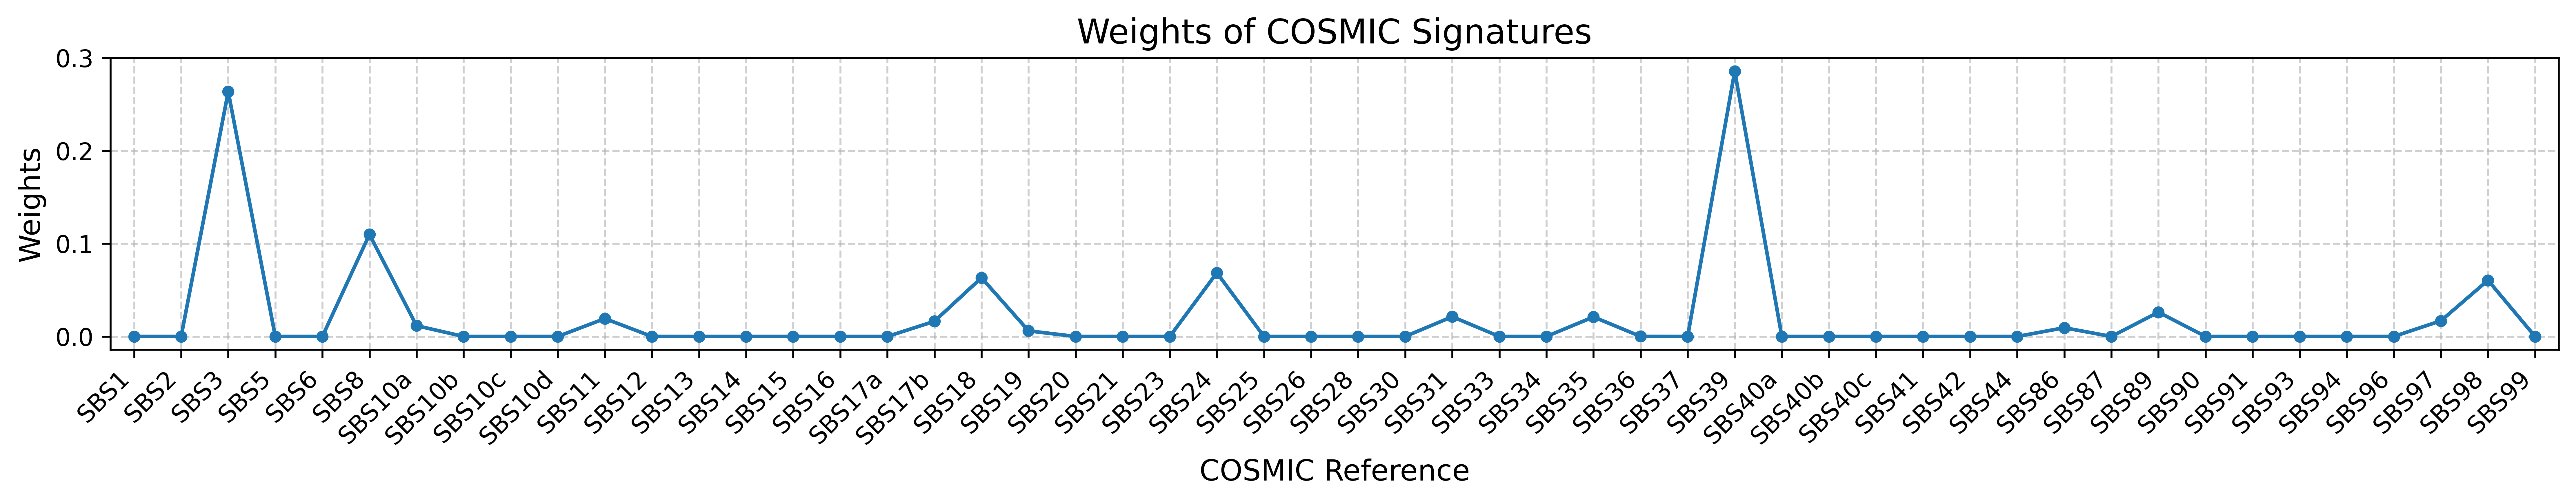

In [ ]:
plt.figure(figsize=(15, 3), dpi=600)

# Get the column names and values
x_labels = decompose_weight_df.columns
y_values = decompose_weight_df.iloc[0]  # Get the values from the first (and only) row
x_values = np.arange(len(x_labels))

plt.plot(x_values, y_values, marker='o', linestyle='-', markersize=4)
plt.xlabel('COSMIC Reference', fontsize=12)  # More generic x-label
plt.ylabel('Weights', fontsize=12)  # More generic y-label
plt.title('Weights of COSMIC Signatures', fontsize=14)
plt.xticks(x_values, x_labels, rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(-0.5, len(x_labels) - 0.5)
plt.tight_layout()
plt.show()

In [ ]:
decompose_weight_df.columns

Index(['SBS1', 'SBS2', 'SBS3', 'SBS5', 'SBS6', 'SBS8', 'SBS10a', 'SBS10b',
       'SBS10c', 'SBS10d', 'SBS11', 'SBS12', 'SBS13', 'SBS14', 'SBS15',
       'SBS16', 'SBS17a', 'SBS17b', 'SBS18', 'SBS19', 'SBS20', 'SBS21',
       'SBS23', 'SBS24', 'SBS25', 'SBS26', 'SBS28', 'SBS30', 'SBS31', 'SBS33',
       'SBS34', 'SBS35', 'SBS36', 'SBS37', 'SBS39', 'SBS40a', 'SBS40b',
       'SBS40c', 'SBS41', 'SBS42', 'SBS44', 'SBS86', 'SBS87', 'SBS89', 'SBS90',
       'SBS91', 'SBS93', 'SBS94', 'SBS96', 'SBS97', 'SBS98', 'SBS99'],
      dtype='object')

In [ ]:
# Get the column names and values
sorted_indices = np.argsort(y_values)[::-1]  # Get indices of sorted y_values (descending)
sorted_x_labels = [x_labels[i] for i in sorted_indices]
sorted_x_labels[:3]

['SBS39', 'SBS3', 'SBS8']

# Compare our de novo sig and the top 3 decomposed COSMIC reference

In [ ]:
decompose_weight_df

,SBS1,SBS2,SBS3,SBS5,SBS6,SBS8,SBS10a,SBS10b,SBS10c,SBS10d,...,SBS87,SBS89,SBS90,SBS91,SBS93,SBS94,SBS96,SBS97,SBS98,SBS99
0,2.408104e-09,1.073272e-09,0.26373,6.590937e-09,2.688369e-09,0.109901,0.011638,1.830188e-09,5.993249e-09,3.361307e-08,...,6.526209e-09,0.026165,2.942191e-09,1.466203e-07,5.756367e-09,2.513631e-08,8.840998e-08,0.016893,0.060557,2.718651e-08


<ipython-input-21-c8592ed88273>:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{tick:.0f} %" for tick in ax.get_yticks()])
<ipython-input-21-c8592ed88273>:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{tick:.0f} %" for tick in ax.get_yticks()])
<ipython-input-21-c8592ed88273>:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{tick:.0f} %" for tick in ax.get_yticks()])
<ipython-input-21-c8592ed88273>:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{tick:.0f} %" for tick in ax.get_yticks()])


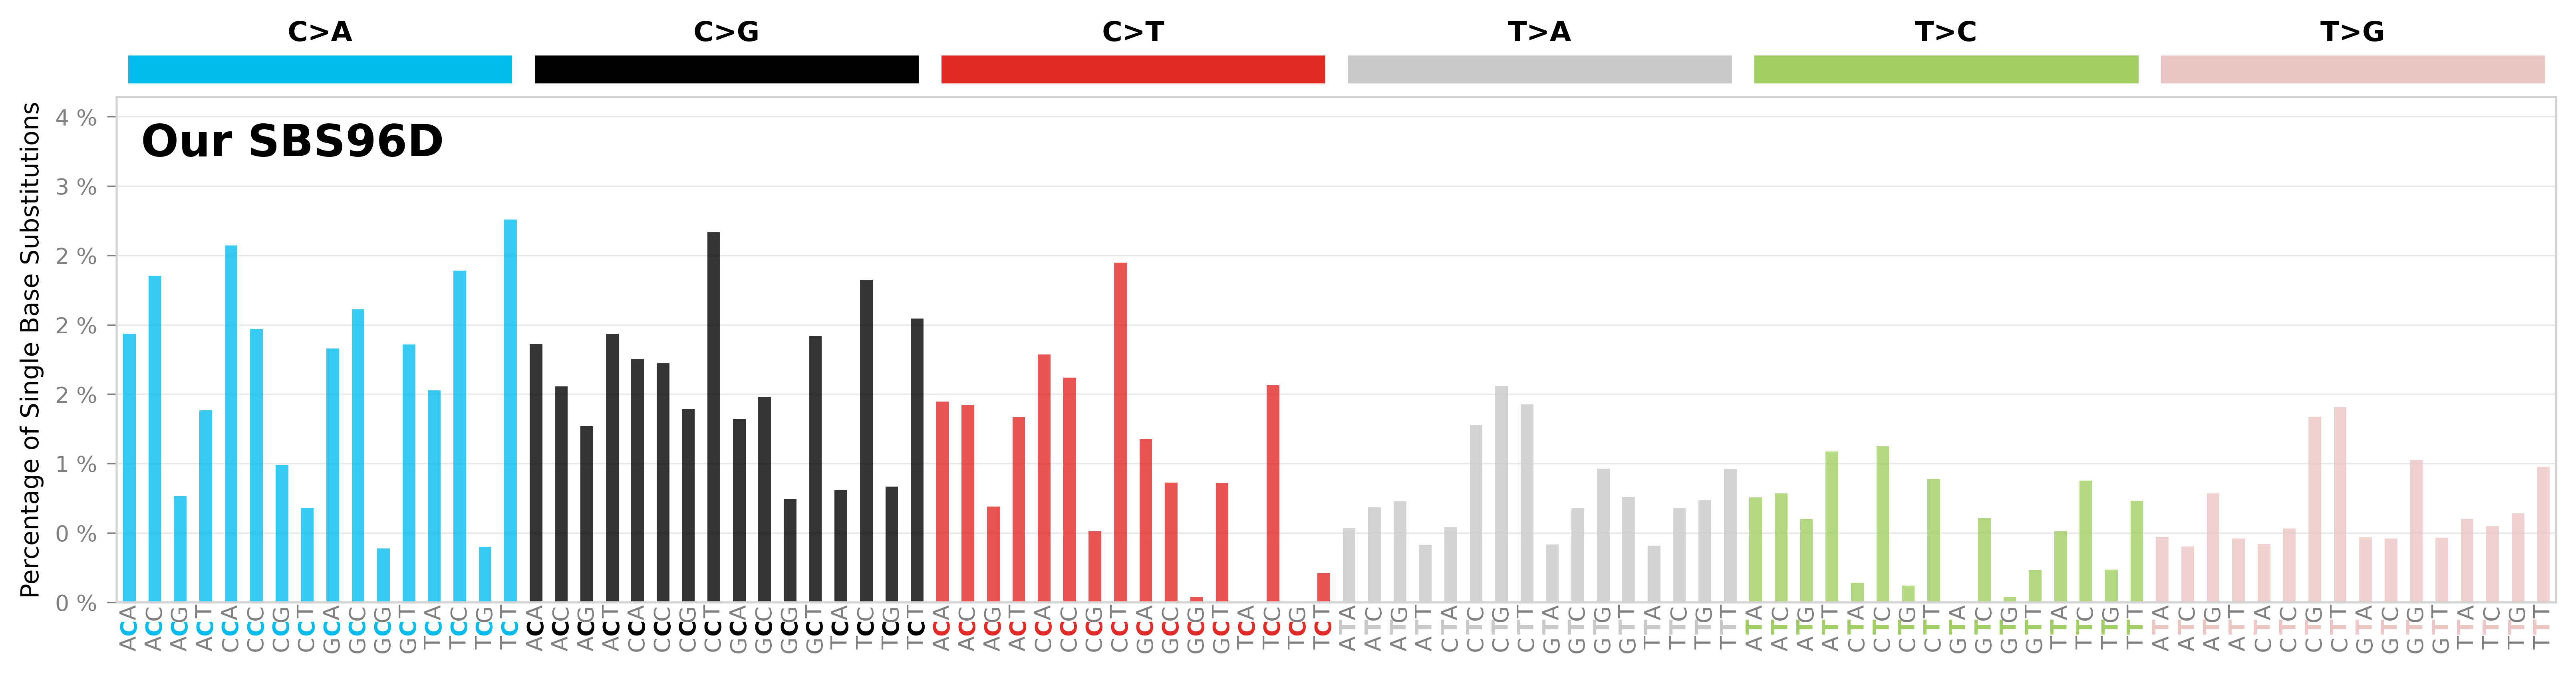

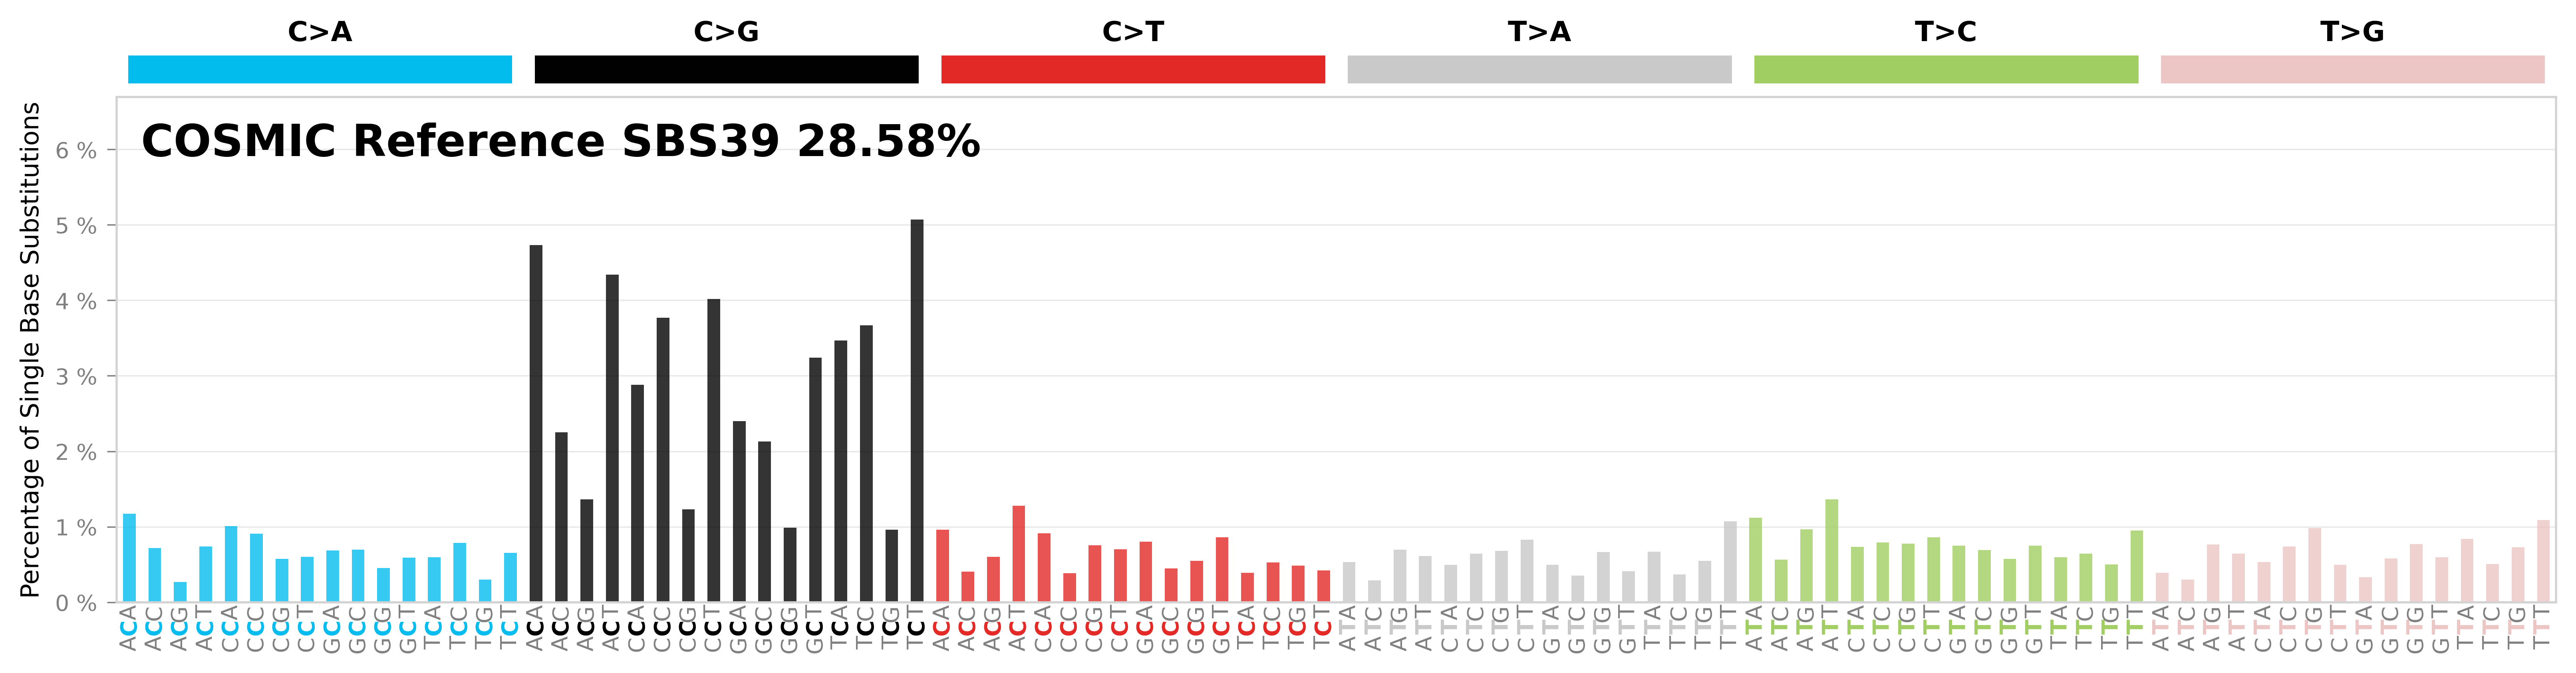

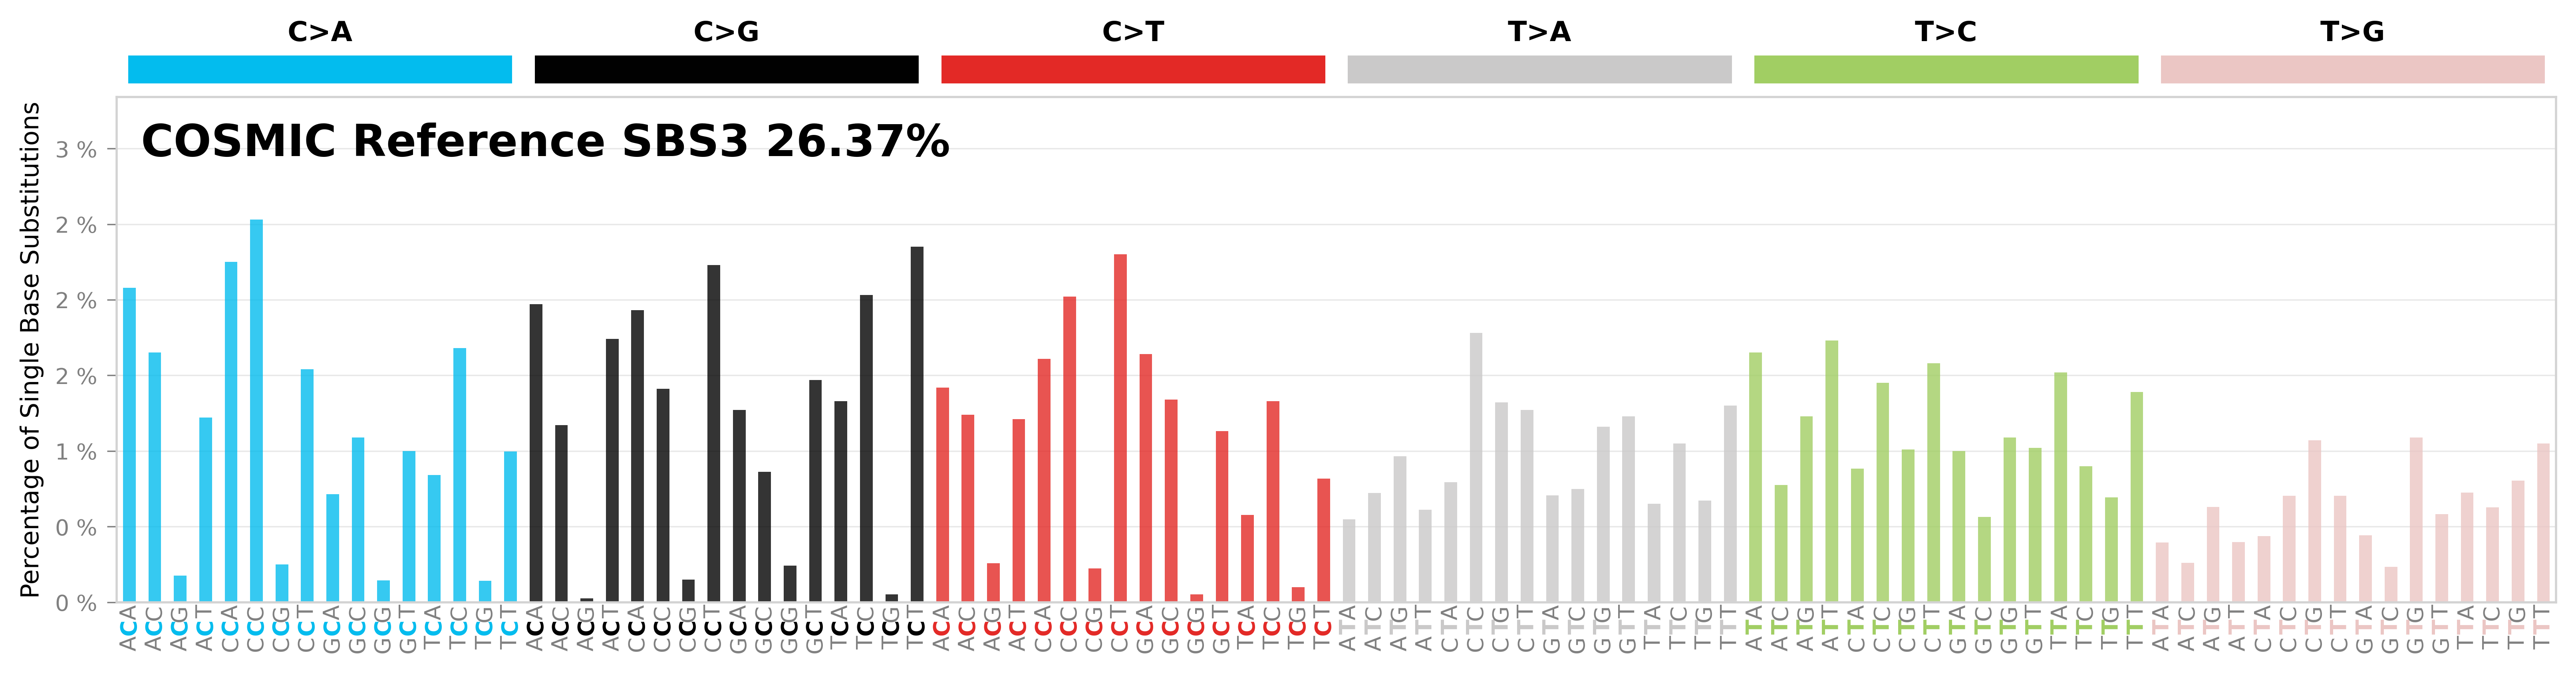

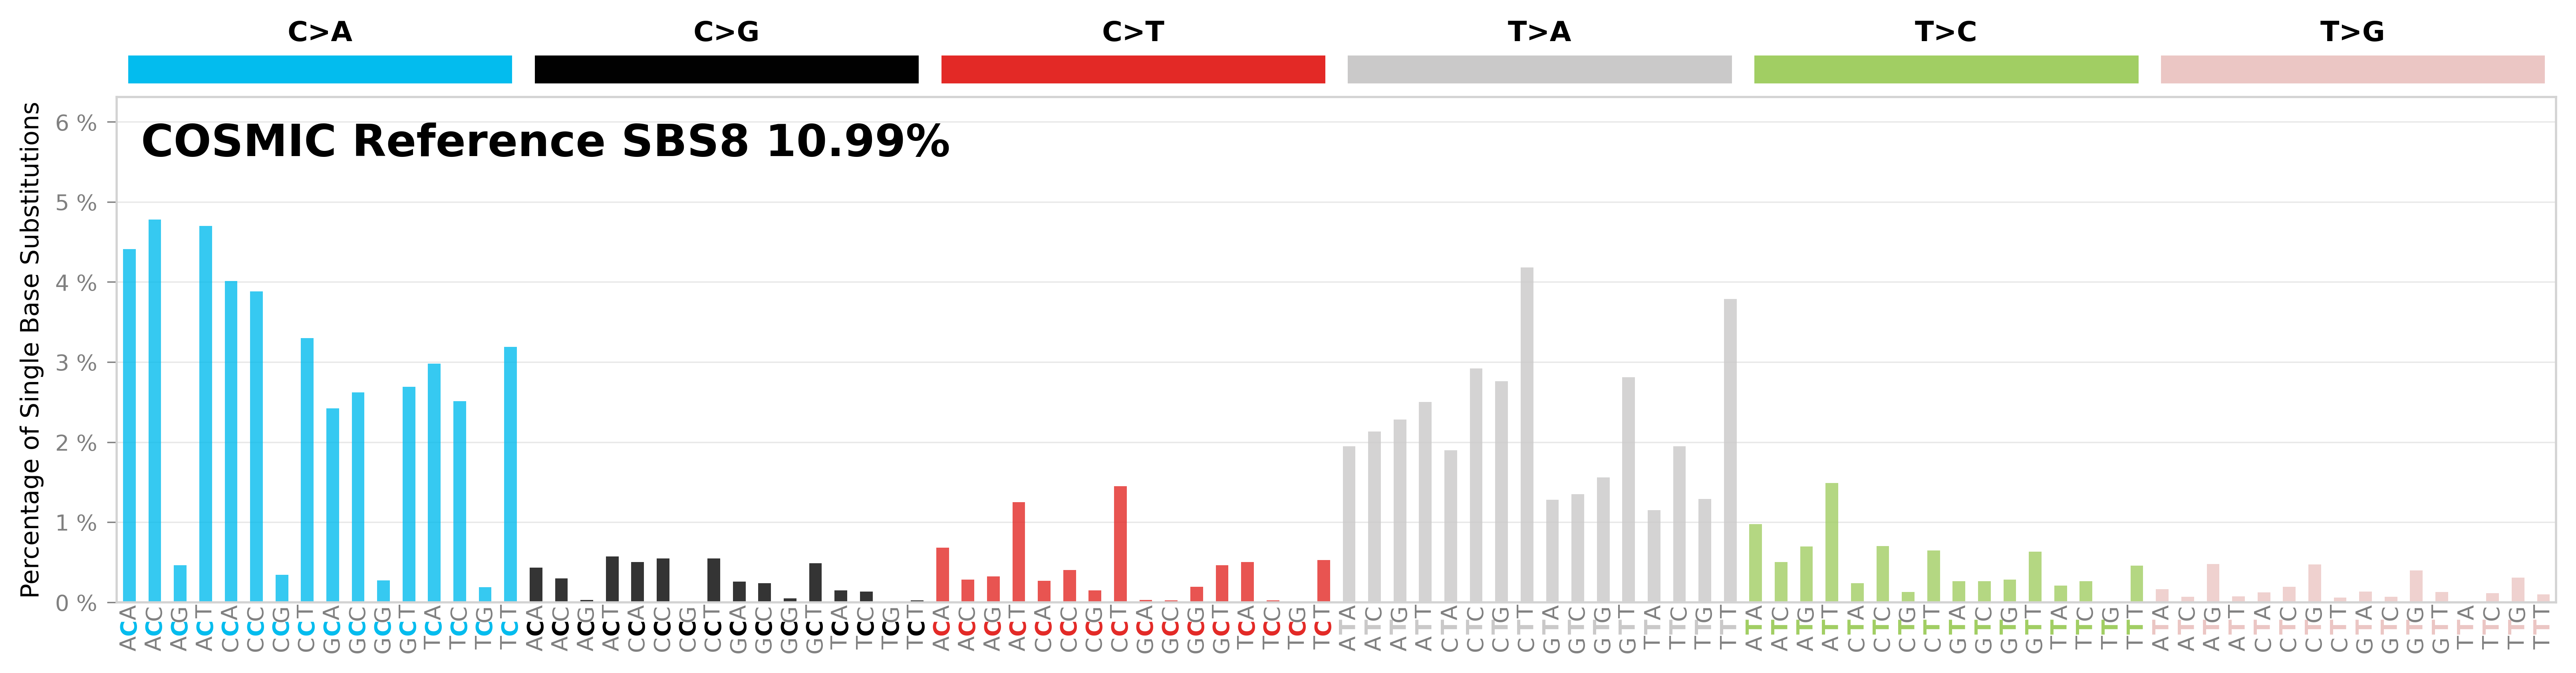

In [ ]:
df_de_novo.index = df_cosmic["Type"]
plot_centroid_column(df_de_novo[signature], df_de_novo.index, f"Our SBS96{chr(65 + signature)}", weight=0)

for sig in sorted_x_labels[:3]:
  weight_percentage = decompose_weight_df[sig][0] * 100
  cosmic_to_plot = df_cosmic_filtered[sig]
  cosmic_to_plot.index = df_cosmic["Type"]
  plot_centroid_column(cosmic_to_plot, cosmic_to_plot.index, f"COSMIC Reference {sig}", weight=weight_percentage)

Top 3 COSMIC signatures: SBS39, SBS3, SBS8
Their weights: [np.float64(0.28578222869286113), np.float64(0.2637300854443886), np.float64(0.10990098028666437)], sum to 0.6594132944239142
Cosine similarity with our de novo: 0.9196067224926656
Correlation: 0.7178534570787013


<ipython-input-21-c8592ed88273>:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{tick:.0f} %" for tick in ax.get_yticks()])


<Axes: ylabel='Percentage of Single Base Substitutions'>

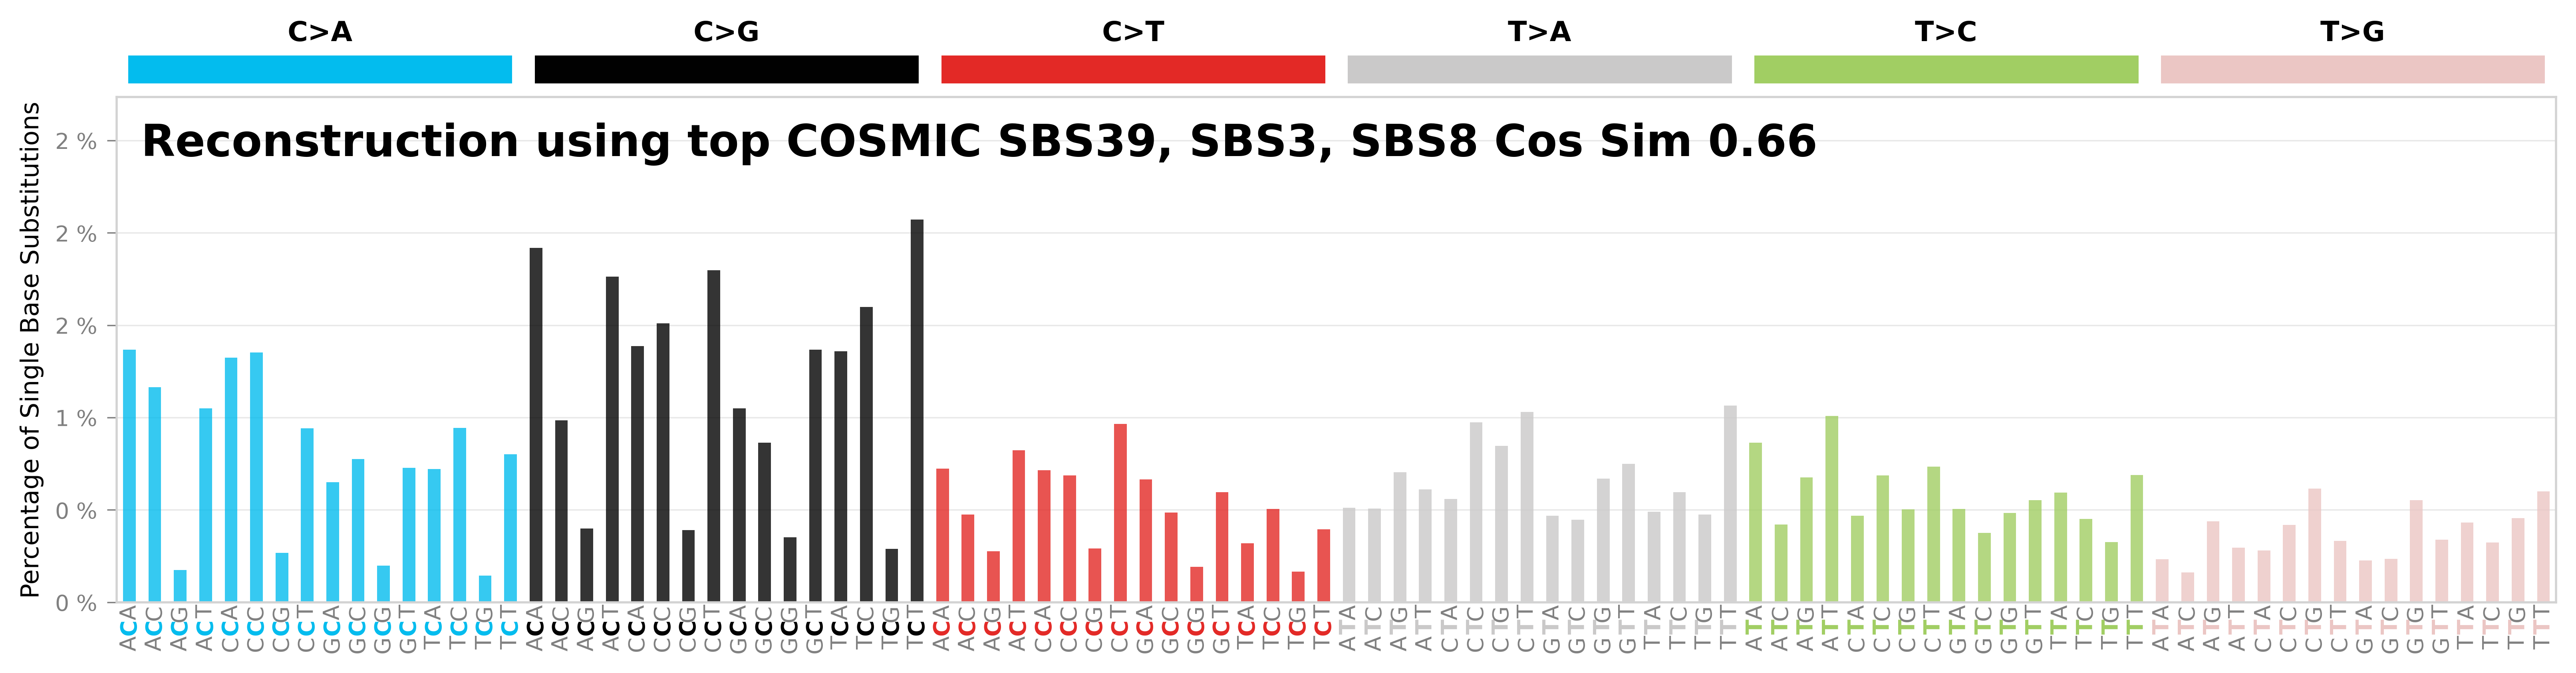

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
# Get the top 3 signatures
top_3_signatures = sorted_x_labels[:3]
name = ", ".join(top_3_signatures)
print(f"Top 3 COSMIC signatures: {name}")

# Get the weights of the top 3 signatures
top_3_weights = [decompose_weight_df[sig][0] for sig in top_3_signatures]
print(f"Their weights: {top_3_weights}, sum to {sum(top_3_weights)}")

# Get the corresponding signatures from the cosmic dataframe
cosmic_signatures = [df_cosmic_filtered[sig] for sig in top_3_signatures]

# Reconstruct the signature
reconstructed_signature = np.zeros(cosmic_signatures[0].shape[0])  # Initialize with the shape of a single signature

for i, sig in enumerate(cosmic_signatures):
    reconstructed_signature += top_3_weights[i] * sig.values # changed sig to sig.values


# Calculate cosine similarity and correlation
cosine_similarity_value = cosine_similarity(de_novo[:,signature].reshape(1, -1), reconstructed_signature.reshape(1, -1))[0, 0]
correlation_value = np.corrcoef(de_novo[:,signature], reconstructed_signature)[0, 1]
print(f"Cosine similarity with our de novo: {cosine_similarity_value}")
print(f"Correlation: {correlation_value}")


df_reconstructed = pd.DataFrame(reconstructed_signature, index = df_de_novo.index, columns=["Reconstructed"])
plot_centroid_column(df_reconstructed["Reconstructed"], df_reconstructed.index, f"Reconstruction using top COSMIC {name}", weight=sum(top_3_weights))


In [4]:
!wget https://raw.githubusercontent.com/CNsquared/breast-cancer-team-1/main/project-3/data/processed/BRCA.SBS96.all
df_mut = pd.read_csv('/content/BRCA.SBS96.all', sep='\t')
df_mut

--2025-05-15 05:11:16--  https://raw.githubusercontent.com/CNsquared/breast-cancer-team-1/main/project-3/data/processed/BRCA.SBS96.all
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 163424 (160K) [text/plain]
Saving to: ‘BRCA.SBS96.all.1’

BRCA.SBS96.all.1    100%[===================>] 159.59K  --.-KB/s    in 0.1s    

2025-05-15 05:11:17 (1.26 MB/s) - ‘BRCA.SBS96.all.1’ saved [163424/163424]



,MutationType,TCGA-3C-AAAU,TCGA-3C-AALI,TCGA-3C-AALJ,TCGA-3C-AALK,TCGA-4H-AAAK,TCGA-5L-AAT0,TCGA-5L-AAT1,TCGA-5T-A9QA,TCGA-A1-A0SB,...,TCGA-UL-AAZ6,TCGA-UU-A93S,TCGA-V7-A7HQ,TCGA-W8-A86G,TCGA-WT-AB41,TCGA-WT-AB44,TCGA-XX-A899,TCGA-XX-A89A,TCGA-Z7-A8R5,TCGA-Z7-A8R6
0,A[C>A]A,0,3,0,0,1,1,3,0,0,...,4,4,0,0,0,1,0,1,1,0
1,A[C>A]C,1,3,3,0,1,0,3,0,0,...,0,3,2,1,0,0,0,0,0,0
2,A[C>A]G,1,0,1,0,0,0,1,0,0,...,1,1,0,0,0,0,0,0,1,0
3,A[C>A]T,0,2,0,0,0,0,0,0,0,...,1,3,0,0,0,0,0,0,0,0
4,A[C>G]A,0,1,1,0,0,0,3,1,1,...,0,1,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,T[T>C]T,0,0,0,1,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
92,T[T>G]A,0,0,1,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
93,T[T>G]C,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
94,T[T>G]G,0,0,1,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0


In [25]:
mut = df_mut.drop(columns=['MutationType']).to_numpy()
sign = df_de_novo.to_numpy()*5000

In [26]:
mut.shape

(96, 789)

In [27]:
sign.shape

(96, 4)

In [29]:
np.linalg.pinv(sign)@mut

array([[ 0.00114007,  0.13192977,  0.00181093, ...,  0.04083396,
        -0.00041346,  0.01332911],
       [ 0.00300801,  0.00252339,  0.000932  , ...,  0.0021048 ,
         0.00153524,  0.00263471],
       [ 0.00428193,  0.01205862,  0.00436108, ...,  0.00534876,
         0.00719834,  0.00657064],
       [ 0.0003828 ,  0.01794993,  0.00579549, ...,  0.00603466,
        -0.0009192 , -0.00125982]])

In [61]:
H = cp.Variable((sign.shape[1],mut.shape[1]), nonneg=True)
cost = cp.norm(mut-sign@H, 2)
objective = cp.Minimize(cost)
constraints = []
prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.SCS,verbose=True)

                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) May 15 05:39:38 AM: Your problem has 3156 variables, 0 constraints, and 0 parameters.
(CVXPY) May 15 05:39:38 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 15 05:39:38 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 15 05:39:38 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 15 05:39:38 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 15 05:39:38 AM: Compiling problem (target solver=SCS).
(CV

277.1114341252639

In [64]:
H.value

array([[1.21783682e-04, 1.32746271e-01, 2.38212054e-03, ...,
        4.04887944e-02, 1.66632737e-03, 1.12914519e-02],
       [1.60551391e-04, 3.15743773e-02, 6.98320460e-03, ...,
        1.12322227e-02, 1.54262251e-02, 2.79863618e-04],
       [9.12037903e-03, 1.87628772e-03, 2.27598376e-04, ...,
        1.66269813e-03, 1.21372362e-04, 1.30212433e-02],
       [2.56061059e-04, 4.56737538e-02, 2.04244144e-02, ...,
        5.22257571e-02, 2.50955297e-03, 4.28204929e-04]])

In [57]:
import numpy as np
from scipy.optimize import minimize

# Assume sign and mut are already defined numpy arrays
m, n = sign.shape[1], mut.shape[1]  # Shape of H: (m, n)

# Flatten H for scipy (since it works with 1D vectors)
def objective(H_flat):
    H = H_flat.reshape((m, n))
    residual = mut - sign @ H
    return np.linalg.norm(residual, 'fro')  # Frobenius norm (same as L2 norm of matrix)

# Initial guess: small positive values
x0 = np.ones(m * n) * 1e-6

# Bounds: H ≥ 0 (element-wise)
bounds = [(0, None)] * (m * n)

# Run optimization
result = minimize(objective, x0, method='L-BFGS-B', bounds=bounds,options={
        'ftol': 1e-8,     # Function value tolerance (convergence criterion)
        'gtol': 1e-6,     # Gradient tolerance (for some solvers)
        'maxiter': 100000,  # Maximum iterations
        'disp': True      # Display convergence messages
    })

In [58]:
# Reshape result back to matrix form
H_opt = result.x.reshape((m, n))

In [59]:
H_opt.shape

(4, 789)

In [60]:
np.linalg.norm(mut-sign@H_opt, 2)

np.float64(343.3656747291445)